In [276]:
%matplotlib inline
from IPython.core.pylabtools import figsize

# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')

import time
import application.model as data_model
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt

In [99]:
class Grader(object):
    def __init__(self, name):
        self.name = name
        self.handins = list()
        
    def set_bias(self, mean, precision):
        self.mean = mean
        self.precision = precision
    
    def get_bias(self):
        return np.random.normal(self.mean,np.sqrt(1.0/self.precision))
        
    def add_handin(self, handin):
        self.handins.append(handin)
        
    def grade_handins(self,n_v):
        for handin in self.handins:
            handin.add_mock_gradeing(self,n_v)


class Handin:
    def __init__(self,title,owner):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
    
    def set_score(self, mean, precision):
        self.mean = mean
        self.precision = precision
    
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_gradeing(self,grader,value):
        self.gradeings[grader.name] = value
        
    def get_score(self):
        return np.random.normal(self.mean,np.sqrt(1.0/self.precision))

    def add_mock_gradeing(self,grader,n_v):
        self.gradeings[grader.name] = np.random.normal(self.get_score()+grader.get_bias(),np.sqrt(1.0/n_v))

        
class Assignment(object):
    
    def __init__(self, handins_input, graders_input,n_gradings):
        self.handins = dict()
        self.graders = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
        
    def grade_mock_handins(self,n_gradings,n_v):
        self.n_gradings = n_gradings
        # Distribute handins
        for i in xrange(0,n_gradings):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
        
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins(n_v)
            
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        #i = int(random.uniform(0,len(sorted_l)))
        i = 0
        handin = sorted_l[i]
        while handin in grader.handins or (handin.owner.name == grader.name):
        #while(handin.owner.name == grader.name):
            i += 1
            #i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin


In [9]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def user_id(user_name):
    for user in data_model.User.objects(name=user_name):
        return user.id

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            max_value = max(map(int,question.numericalAnswers.keys()))
            return max_value
        else:
            return 5

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def score_handin(report_grade):
    answers = data_model.Answer.objects(report_grade=report_grade)
    handin_n = 0.0
    handin_acc = 0.0
    for answer in answers:
        if answer.text_answer == None:
            handin_acc = handin_acc + answer_value(answer)
            handin_n = handin_n + 1.0
    return handin_acc / handin_n


In [10]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    ## Create dictionary for holding the graders who have graded a handin
    graders = dict()
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin(str(handin_.id),str(handin_.submitter.id))
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader(str(grade.giver.id))

            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            handins[str(handin_.id)].add_gradeing(graders[str(grade.giver.id)],score_handin(grade))
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment(handins.itervalues(),graders.itervalues(),n_gradings)

In [6]:
def fetch_data(obj):

    res_c = Course()
        
    if type(obj).__name__ == "Course":
        assignments_d = data_model.Assignment.objects(course=obj)
        for assignment_d in assignments_d:
            res_c.add_assignment(fetch_assignment_data(assignment_d))
    elif type(obj).__name__ == "Assignment":
        res_c.add_assignment(fetch_assignment_data(obj))
        
    return res_c

In [19]:
c = data_model.Course.objects.get(title="Computational Tools for Big Data")

In [27]:
t = fetch_data(c)

In [277]:
def gibbs_model(data,samples,burn_in=0):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = dict()
    t_h = dict()
    u_g = dict()
    t_g = dict()
    T = dict()
    B = dict()

    # Draw from priors
    e = np.random.gamma(al_e,1.0 / be_e)
    for h in data.handins.iterkeys():
        t_h[h] = np.random.gamma(al_h,1.0/be_h)
        u_h[h] = np.random.normal(ga_h,np.sqrt(1.0/(la_h * t_h[h])))
        T[h] = np.random.normal(u_h[h],np.sqrt(1.0/t_h[h]))
    for g in data.graders.iterkeys():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))

    # Gibbs sampling #    
    # Tracers initialising
    acc_e = list()
    acc_u_h = defaultdict(list)
    acc_t_h = defaultdict(list)
    acc_u_g = defaultdict(list)
    acc_t_g = defaultdict(list)
    acc_T = defaultdict(list)
    acc_B = defaultdict(list)
    
    tw = time.time()
    
    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            n_gradings = len(handin.graders)
            sum_ = 0.0
            for g, val in handin.gradeings.iteritems():
                sum_ = sum_ + val - B[g]
            v = e*n_gradings+t_h[h]
            T[h] = np.random.normal((u_h[h]*t_h[h]+e*sum_)/v,np.sqrt(1.0/v))

        # Sample B
        for g, grader in data.graders.iteritems():
            n_gradings = len(grader.handins)
            sum_ = 0.0
            for h in grader.handins:
                sum_ = sum_ + h.gradeings[g] - T[h.title]
            v = e*n_gradings+t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+e*sum_)/v,np.sqrt(1.0/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0.0
        for h, handin in data.handins.iteritems():
            for g, grading in data.handins[h].gradeings.iteritems():
                sum_ = sum_ + np.square(grading - (T[h]+B[g]))
                n_eval = n_eval + 1.0
        e = np.random.gamma(al_e+0.5*n_eval,1.0/(be_e+0.5*sum_))
        
        # Sample u_h and t_h
        for h in data.handins.iterkeys():
            la_ = (la_h+1.0)
            al_ = al_h+0.5
            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
            t_h[h] = np.random.gamma(al_,1.0/be_)
            u_h[h] = np.random.normal((la_h*ga_h+T[h])/la_,np.sqrt(1.0 / (la_*t_h[h])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+1.0)
            al_ = al_g+0.5
            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0 / (la_*t_g[g])))
        
        # Collect tracings
        if r > burn_in:
            acc_e.append(e)
            for h in data.handins.iterkeys():
                acc_u_h[h].append(u_h[h])
                acc_t_h[h].append(t_h[h])
                acc_T[h].append(T[h])
            for g in data.graders.iterkeys():
                acc_u_g[g].append(u_g[g])
                acc_t_g[g].append(t_g[g])
                acc_B[g].append(B[g])    
                
    print
    print "Wall time: %f" % (time.time() - tw)
    
    traces = {'e' : acc_e,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [30]:
def handin_students(h_id):
    model_handin = data_model.Handin.objects.get(id=ObjectId(h_id))
    students_ = list()
    for student in model_handin.students:
        students_.append(student.name)
    return ", ".join(students_)

In [31]:
def truncate(string,length):
    return (string[:length] + '..') if len(string) > length else string

In [32]:
def plot_bias(t,result):
    scores = list()
    for name, g in t.graders.iteritems():
        scores.append((user_name(ObjectId(name)),result['B'][name],np.sqrt(1.0 /result['t_g'][name])))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    model_2 = map(lambda x : float(x[2]),scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.errorbar(model_1,y,xerr=model_2,fmt='or',label="Gibbs sampling",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.xlim(-0.3,0.3)
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.show()

In [33]:
def plot_handin_score(t,result):

    scores = list()
    for title, handin in t.handins.iteritems():
        l = truncate(handin_students(title),45)
        scores.append((l,result['T'][title],handin.gradeings.values()))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    mean = map(lambda x : x[2],scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.plot(model_1,y,'or',label="Gibbs sampling")
    plt.boxplot(mean, positions=y, vert=False)
#    plt.plot(mean,y,'ob',label="Mean",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*7])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.show()

In [34]:
def get_sorted_result(t,result):
    s = list()
    for name, g in t.graders.iteritems():
        s.append((user_name(ObjectId(name)),result['B'][name]))
    s.sort(key=lambda x:x[1])
    return s

In [35]:
def get_sorted_result_T(t,result):
    s = list()
    for name, h in t.handins.iteritems():
        s.append((h,result['T'][name]))
    s.sort(key=lambda x:x[1])
    return s

In [95]:
def tau_std(value):
    return np.sqrt(1.0 / value)

### Mock Data

In [288]:
handins_data = list()
graders_data = list()

graders = 20
gradings = 5

for i in xrange(graders):
    g = Grader('grader_%i' % i)
    g.set_bias(np.random.normal(0,tau_std(100)),np.random.gamma(50,1.0 / 0.1))
    h_mu = np.random.normal(0.5,tau_std(25))
    while h_mu > 1 or h_mu < 0:
        h_mu = np.random.normal(0.5,tau_std(25))
    h = Handin('handin_%i' % i, g)
    h.set_score(np.random.normal(0.5,tau_std(25)),np.random.gamma(10,1.0/ 0.1))
    graders_data.append(g)
    handins_data.append(h)
    
mock_data = Assignment(handins_data,graders_data,graders*gradings)
mock_data.grade_mock_handins(gradings,np.random.gamma(50,1.0 / 0.1))

In [289]:
def plot_traces_bias_(assignment,mcmc):
    figsize(12.5, 4.5)
    bias_abs = list()
    for i, g in enumerate(assignment.graders.keys()):
        if i < 5:
            continue
            
        plt.subplot(3,1,1) 
        
        b_mu = mcmc['B'][str(g)][:]
        plt.plot(b_mu,color="#467821",label=r'posterior $P(B_{g})$')
        
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
            
        plt.subplot(3,1,2) 
        
        b_mu = mcmc['u_g'][str(g)][:]
        plt.plot(b_mu,color="#467821",label=r'posterior $P(\mu_g)$')
        
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
        
        plt.subplot(3,1,3) 
        b_tau = mcmc['t_g'][str(g)][:]
        plt.plot(b_tau,color="#467821",label=r'posterior $P(\tau_g)$')

        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        plt.tight_layout()
        break

In [290]:
def plot_traces_handin_(assignment,mcmc):
    figsize(12.5, 4.5)
    for i, g in enumerate(assignment.handins.keys()):
        plt.subplot(3,1,1) 
        
        b_mu = mcmc['T'][str(g)][:]
        plt.plot(b_mu,color="#348ABD",label=r'posterior $P(T_h)$')

        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
        
        plt.subplot(3,1,2) 
        
        b_mu = mcmc['u_h'][str(g)][:]
        plt.plot(b_mu,color="#348ABD",label=r'posterior $P(\mu_h)$')
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
        
        plt.subplot(3,1,3) 

        b_tau = mcmc['t_h'][str(g)][:]
        plt.plot(b_tau,color="#348ABD",label=r'posterior $P(\tau_h)$')
        leg = plt.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
        plt.suptitle("Traces of %s" % g, fontsize=12)
        plt.xlabel("Steps")
        plt.show()
        plt.tight_layout()
        break

In [291]:
mock_result = gibbs_model(mock_data,1000)

1000 out of 1000
Wall time: 1.542332


graders:time
20:1.764312
40:3.706723
100:8.567933

In [236]:
np.sqrt(1.0 / np.mean(mock_result['e']))

0.19658635061667212

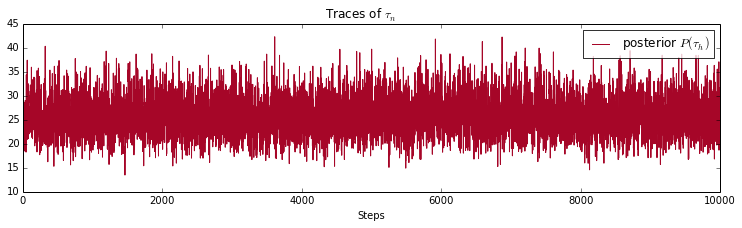

ValueError: max() arg is an empty sequence

In [267]:
figsize(12.5, 3)
e = mock_result['e'][:]
plt.plot(e,color="#A60628",label=r'posterior $P(\tau_h)$')
leg = plt.legend(loc=1)
leg.get_frame().set_alpha(0.8)
plt.suptitle(r'Traces of $\tau_n$', fontsize=12)
plt.xlabel("Steps")
plt.show()
plt.tight_layout()



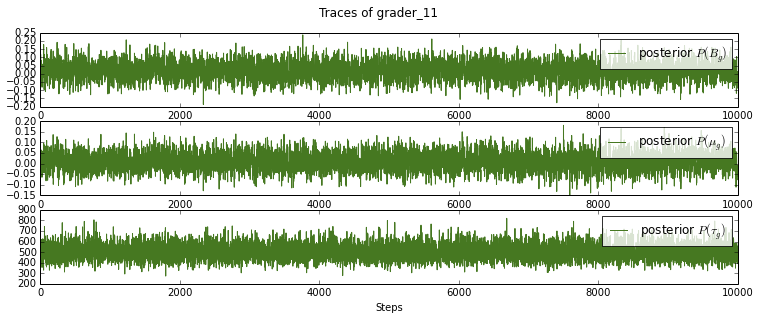

ValueError: max() arg is an empty sequence

In [274]:
plot_traces_bias_(mock_data,mock_result)

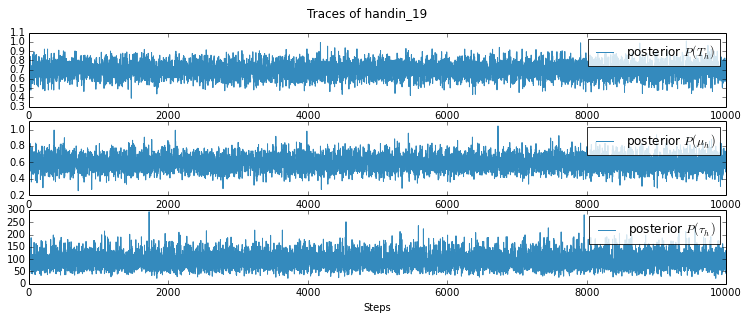

ValueError: max() arg is an empty sequence

In [275]:
plot_traces_handin_(mock_data,mock_result)

In [173]:
def find_bias_(assignment,mcmc,f):
    bias = list()
    for g in assignment.graders.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['t_g'][g][:])
        elif f == 'mean':
            value = np.mean(mcmc['u_g'][g][:])
        bias.append((value,g))
    return bias

In [174]:
def find_T_(assignment,mcmc,f):
    T = list()
    for h in assignment.handins.keys():
        value = 0
        if f == 'var':
            value = np.mean(mcmc['t_h'][h][:])
        elif f == 'mean':
            value = np.mean(mcmc['u_h'][h][:])
        T.append((value,h))
    return T

In [298]:
def compare_to_generated(assignment_data,mcmc_handins,find,func='mean',ax=None):
    bias_abs_1 = find(assignment_data, mcmc_handins, func)
    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = bias_abs_1[:]
    
    for (value, _id) in collected:
        compared[_id] = value
        
    sorted_list = list()
    if "bias" in find.func_name:
        for _id, g in assignment_data.graders.iteritems():
            if func == "mean":
                sorted_list.append((_id,g.mean))
            else:
                sorted_list.append((_id,g.precision))
    else:
        for _id, h in assignment_data.handins.iteritems():
            if func == "mean":
                sorted_list.append((_id,h.mean))
            else:
                sorted_list.append((_id,h.precision))
            
    sorted_list.sort(key=lambda x: x[1])
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    tau_score_values = list()
    MS_val = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if "bias" not in find.func_name:
            if func == "mean":
                mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
                mean_score_values.append(mean_score)
        
        MS_val.append(compared[_id])
        score_values.append(compared[_id])
        true_values.append(value)
        labels.append(_id)
    
    MSE_T = 0.0
    MSE_M = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,MS_val))) / len(true_values)
    print MSE_M
    if "bias" not in find.func_name and func == "mean":
        MSE_T = sum(map(lambda x : (float(x[1]) - float(x[0])) ** 2,zip(true_values,mean_score_values))) / len(true_values)
        print MSE_T
    box_text = ""
    if func == "mean" and ax:
        if "bias" not in find.func_name:
            box_text = 'MSE model: %f\nMSE graded: %f' % (MSE_M,MSE_T)
        else:
            box_text = 'MSE model: %f' % MSE_M
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.95, box_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    y_ = map(lambda x: x,y)
    if "bias" in find.func_name:
        plt.plot(score_values,y_,'o',color="#467821",label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',color="#A60628",label="True value",alpha=0.6,linewidth=0)
    else:
        if func == "mean":
            plt.plot(mean_score_values,y,'o',color="#A60628",label="Mean value of\nobserved scores",alpha=0.6)
        plt.plot(score_values,y,'o',color='#348ABD',label="Expected value of\nposterior",alpha=0.6,linewidth=0)
        plt.plot(true_values,y,'.',label="True value",alpha=0.6,linewidth=0)
    plt.yticks(xrange(0,len(sorted_list)),labels)
    leg = plt.legend(loc=4,numpoints=1)
    leg.get_frame().set_alpha(0.4)
    if "bias" in find.func_name:
        if func == "mean":
            plt.title(r'True $\mu_g$ compared to infered $\mu_g$')
        else:
            plt.title(r'True $\tau_g$ compared to infered $\tau_g$')
        plt.ylabel("Graders")
    else:
        if func == "mean":
            plt.title(r'True $\mu_h$ compared to infered $\mu_h$')
        else:
            plt.title(r'True $\tau_h$ compared to infered $\tau_h$')
        plt.ylabel("Handins")

0.00960976205337
0.00633645928538
490.588450806


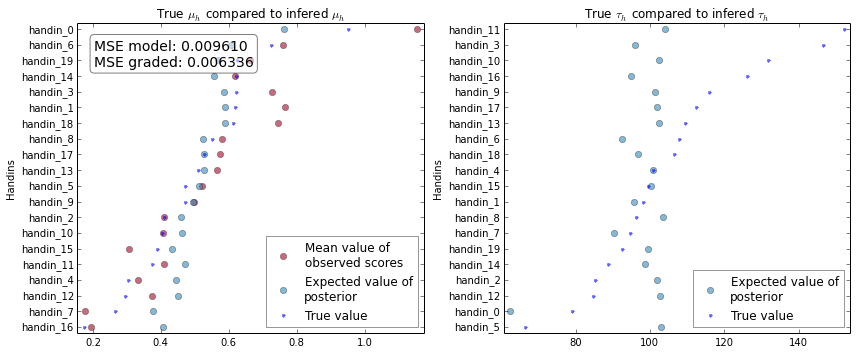

In [299]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated(mock_data,mock_result,find_T_,'mean',ax)
plt.margins(0.02)
plt.subplot(1,2,2)
compare_to_generated(mock_data,mock_result,find_T_,'var')
plt.margins(0.02)
plt.tight_layout()

0.0099713314236
2892.04344928


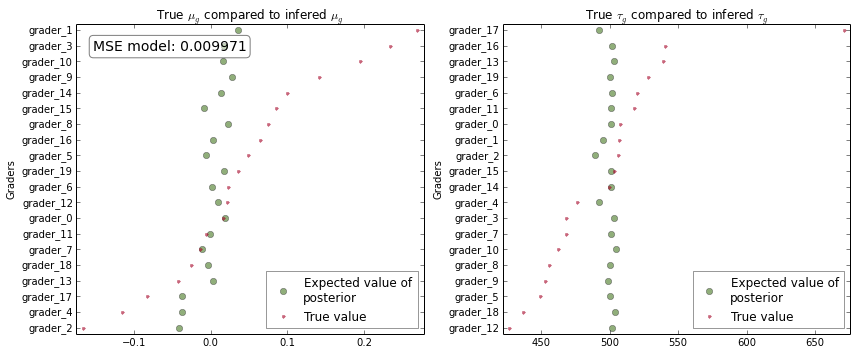

In [300]:
figsize(12,5)
ax = plt.subplot(1,2,1)
compare_to_generated(mock_data,mock_result,find_bias_,'mean',ax)
plt.margins(0.02)
plt.subplot(1,2,2)
compare_to_generated(mock_data,mock_result,find_bias_,'var')
plt.margins(0.02)
plt.tight_layout()

## The entire course

In [28]:
c = data_model.Course.objects.get(title="Computational Tools for Big Data")

In [29]:
course_data = fetch_data(c)

In [285]:
course_result = gibbs_model(course_data)

6000 out of 6000


In [286]:
1.0 / course_result['e']

0.013732127768317962

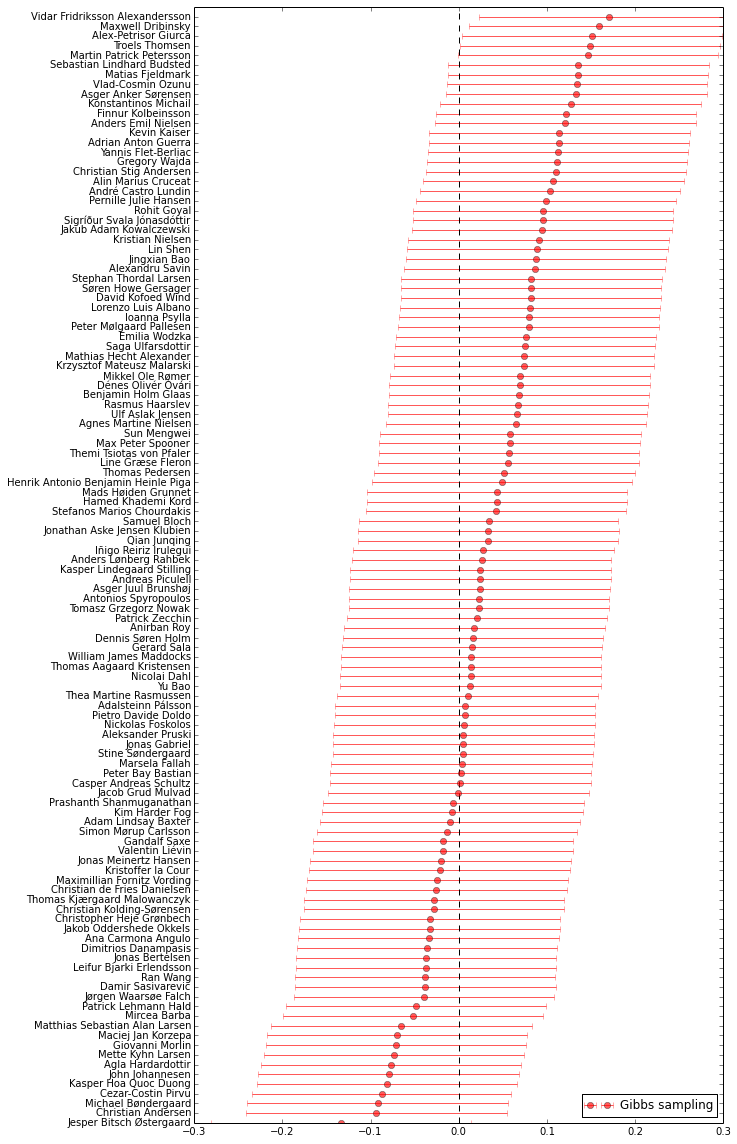

In [287]:
plot_bias(course_data,course_result)

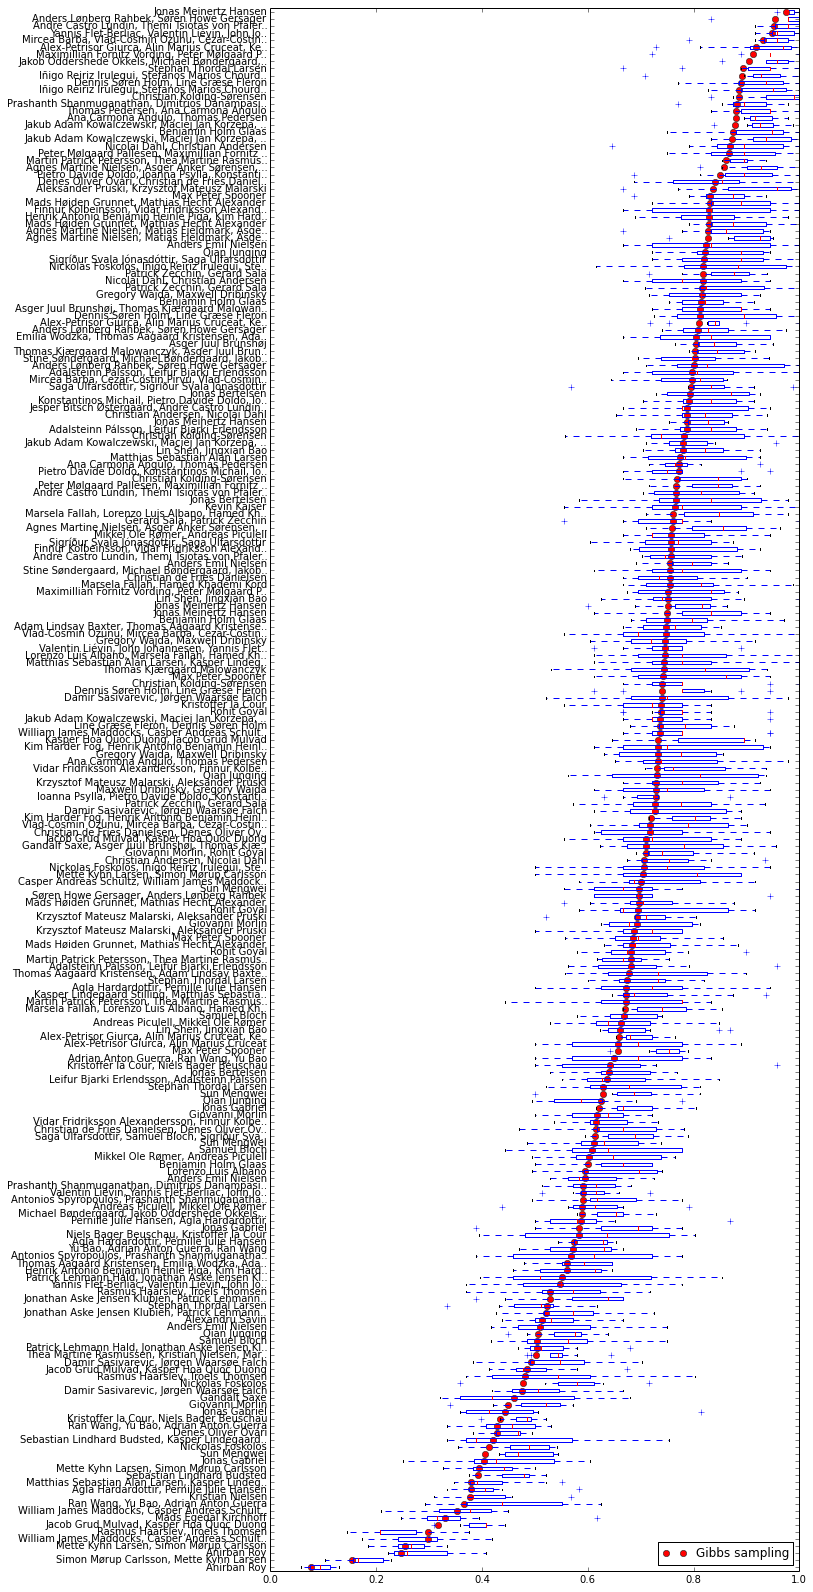

In [288]:
plot_handin_score(course_data,course_result)

## Assignment 1

In [278]:
a1 = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

a1_data = fetch_data(a1)

a1_result = gibbs_model(a1_data)

6000 out of 6000


In [279]:
1.0 / a1_result['e']

0.009618976520815616

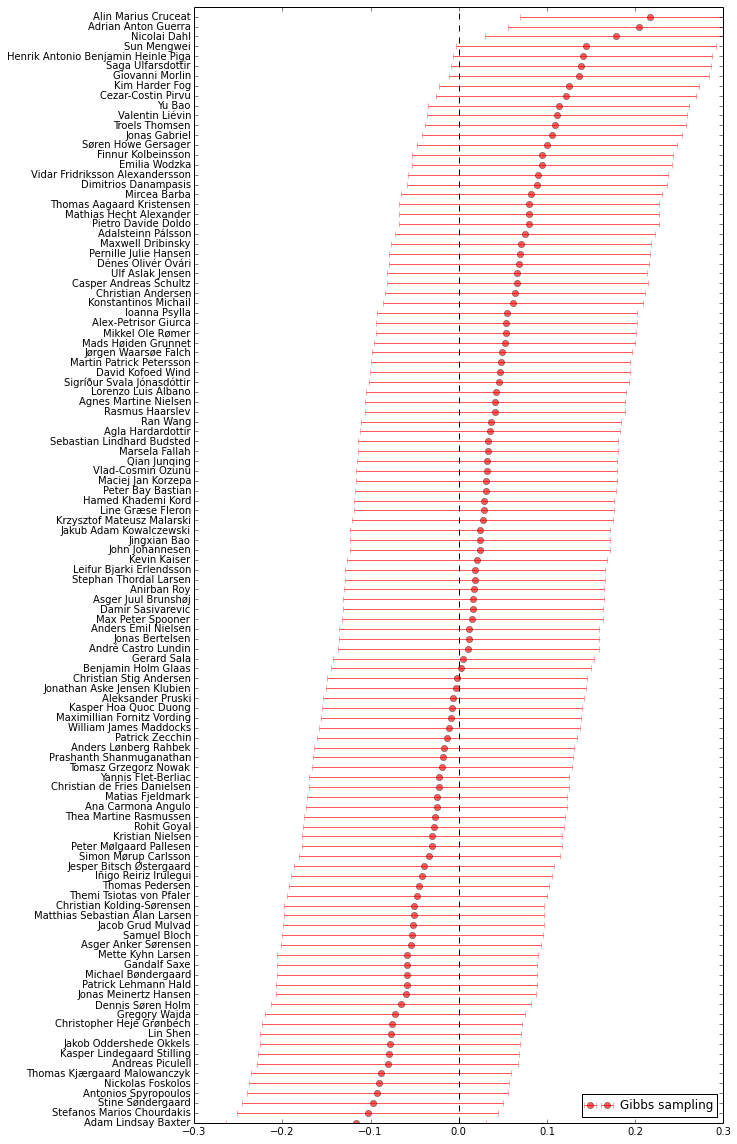

In [280]:
plot_bias(a1_data,a1_result)

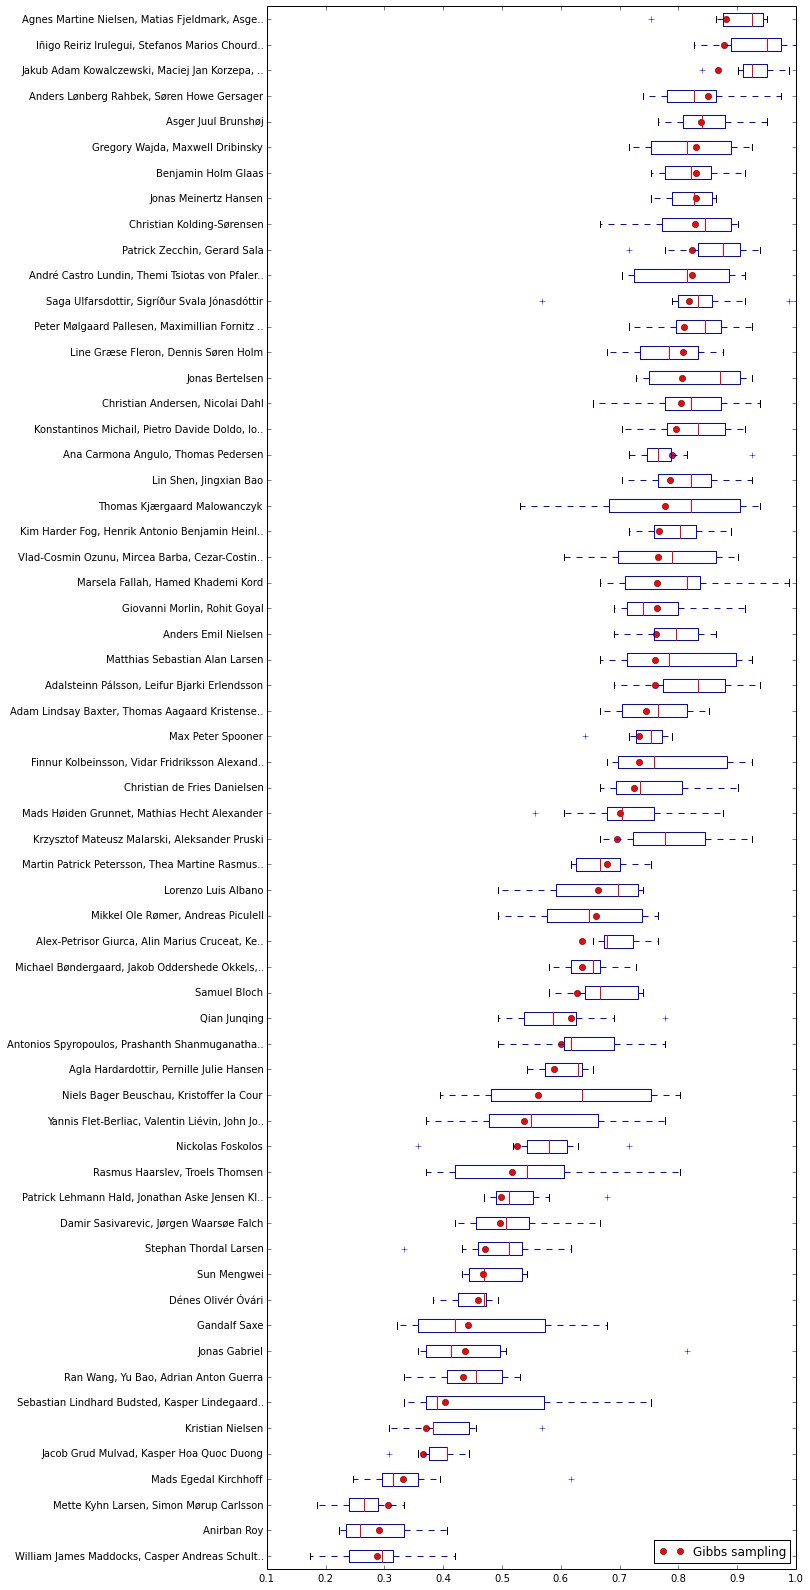

In [289]:
plot_handin_score(a1_data,a1_result)

## Assignment 2

In [290]:
a2 = data_model.Assignment.objects.get(title="Databases and Streaming")

a2_data = fetch_data(a2)

a2_result = gibbs_model(a2_data)

6000 out of 6000


In [291]:
1.0 / a2_result['e']

0.012454518769528865

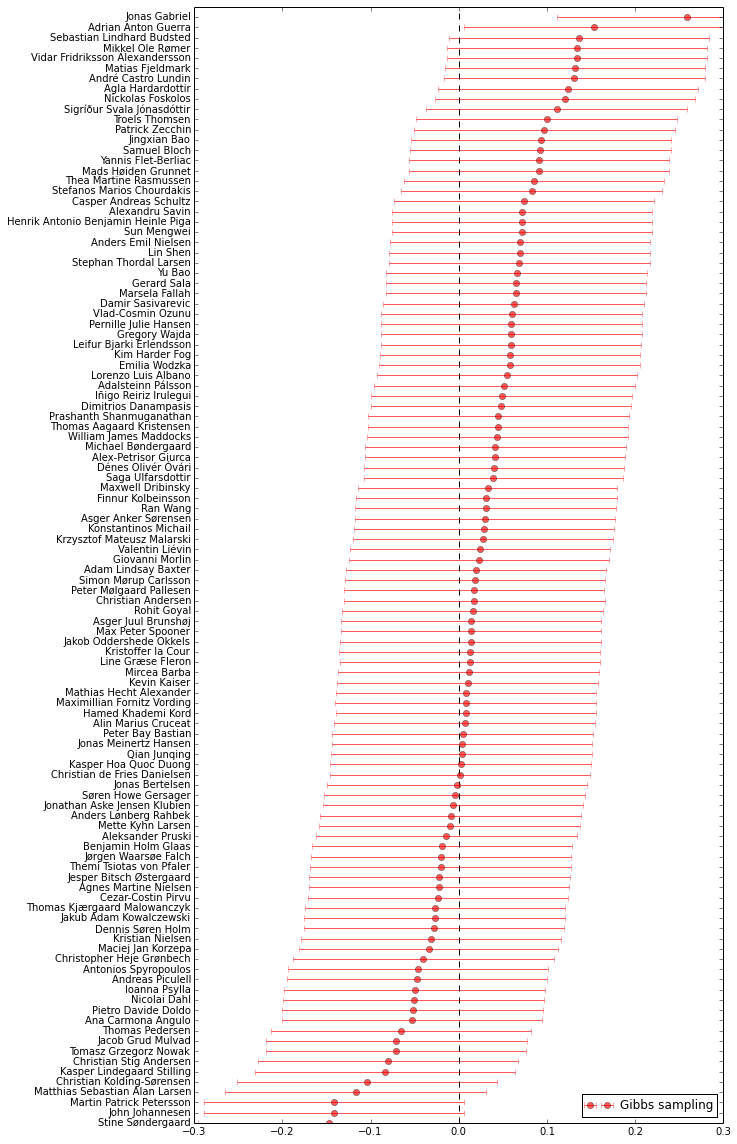

In [292]:
plot_bias(a2_data,a2_result)

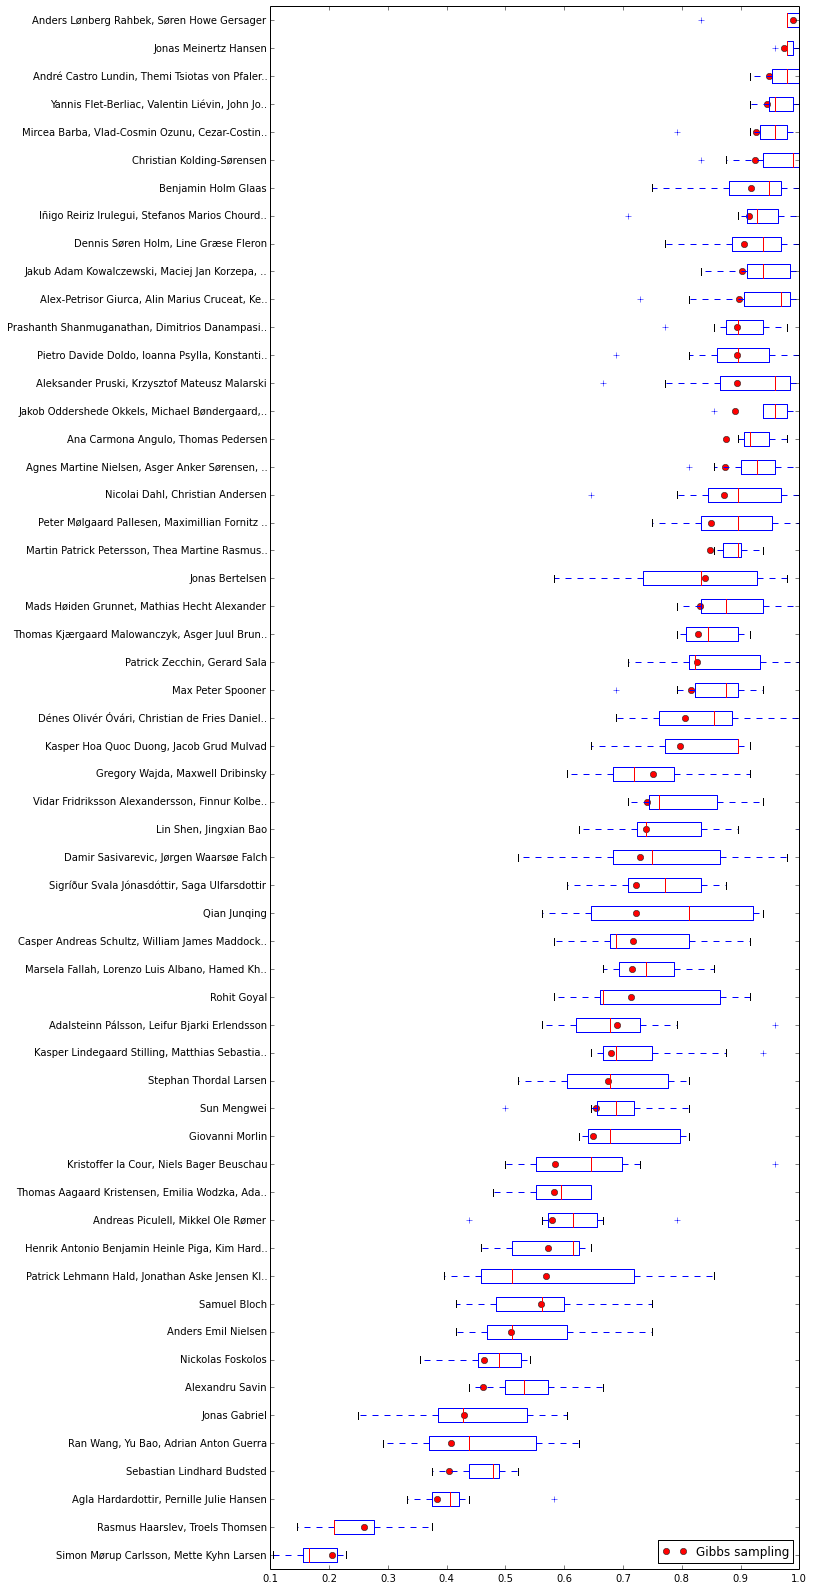

In [293]:
plot_handin_score(a2_data,a2_result)

## Assignment 3

In [294]:
a3 = data_model.Assignment.objects.get(title="Big Data and Deep Learning")

a3_data = fetch_data(a3)

a3_result = gibbs_model(a3_data)

6000 out of 6000


In [295]:
1.0 / a3_result['e']

0.009421146743169346

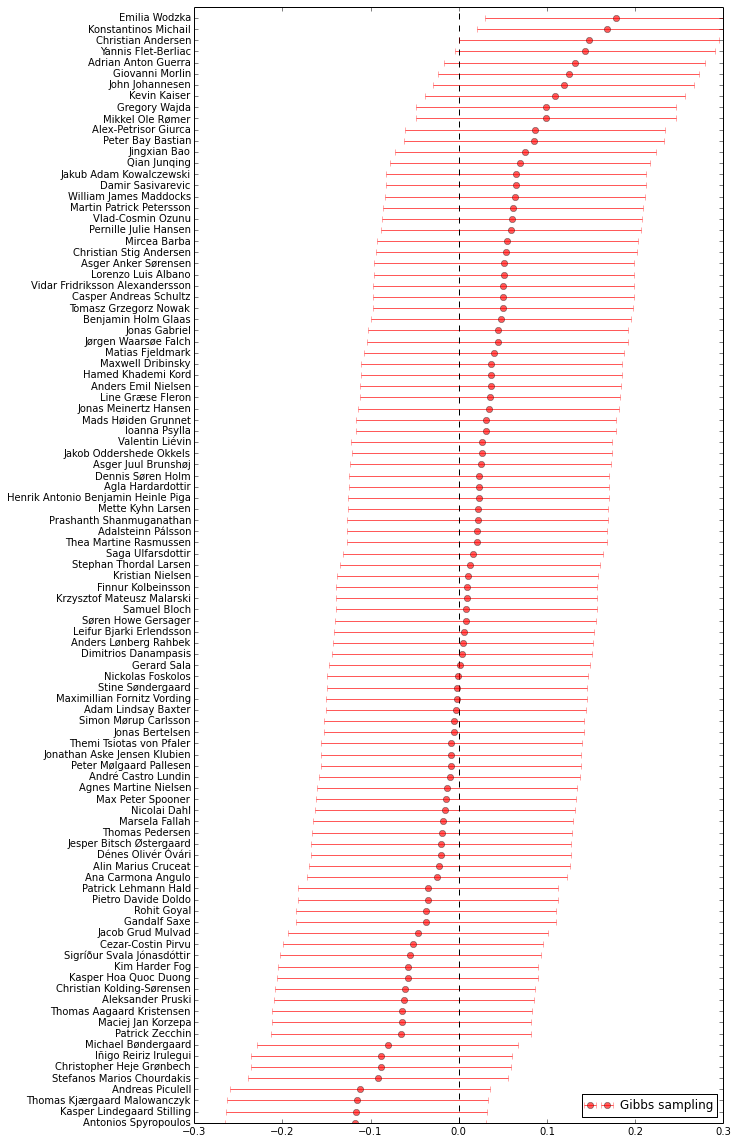

In [296]:
plot_bias(a3_data,a3_result)

In [297]:
sr = get_sorted_result(a3_data,a3_result)

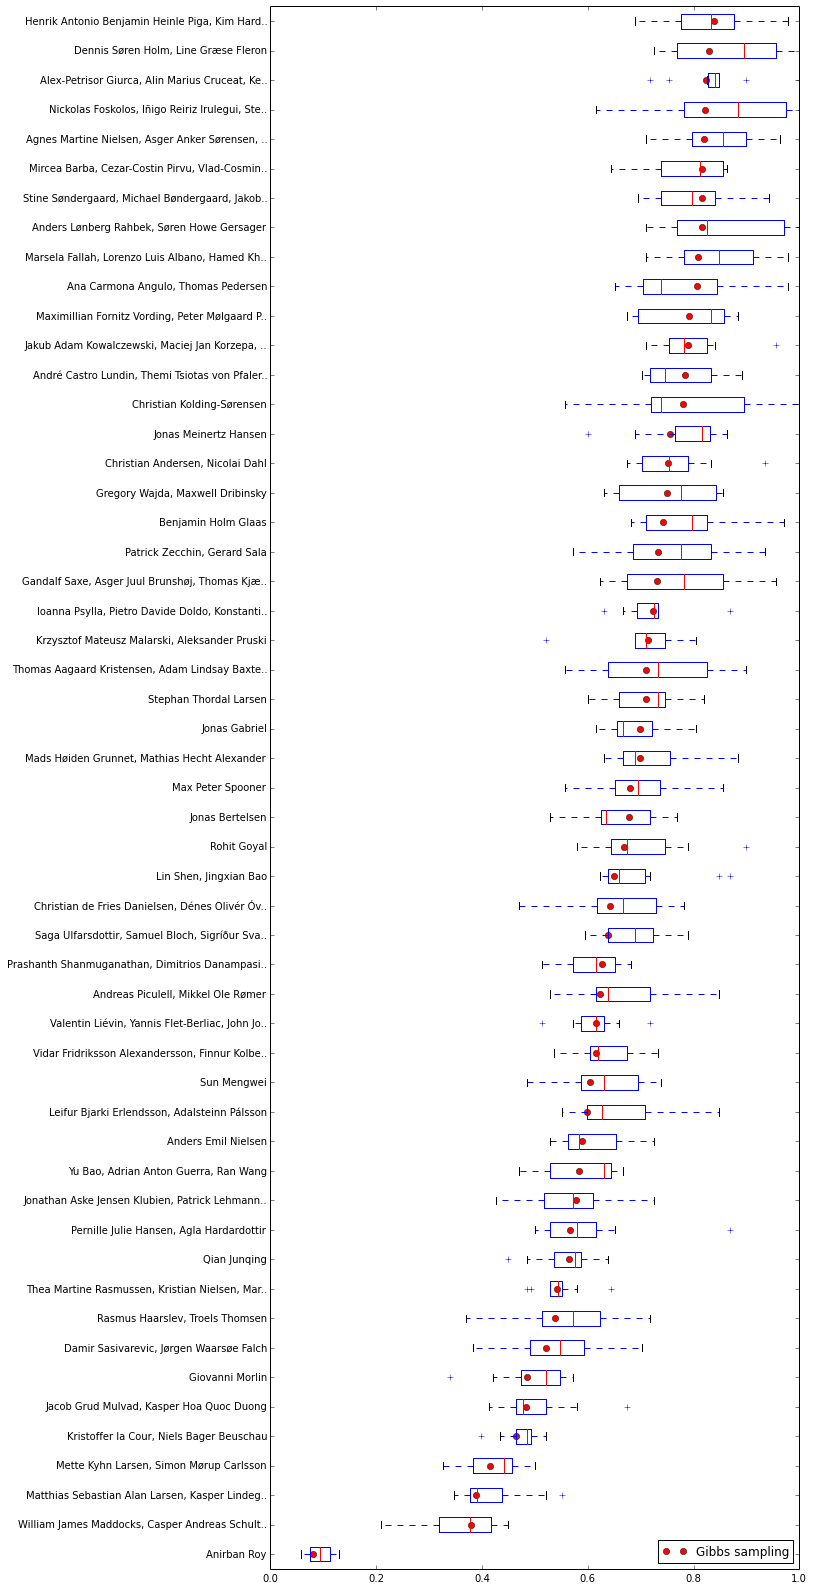

In [298]:
plot_handin_score(a3_data,a3_result)

## Assignment 4

In [299]:
a4 = data_model.Assignment.objects.get(title="Your Choice of Subject")

a4_data = fetch_data(a4)

a4_result = gibbs_model(a4_data)

6000 out of 6000


In [300]:
1.0 / a4_result['e']

0.0138550644671506

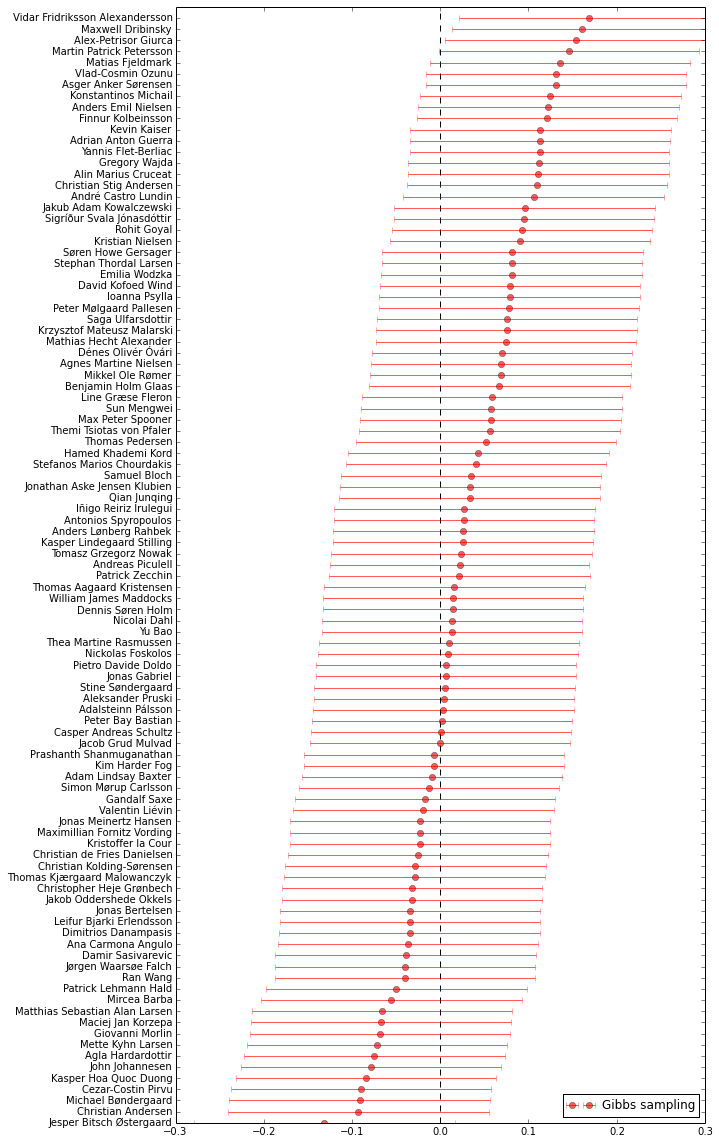

In [301]:
plot_bias(a4_data,a4_result)

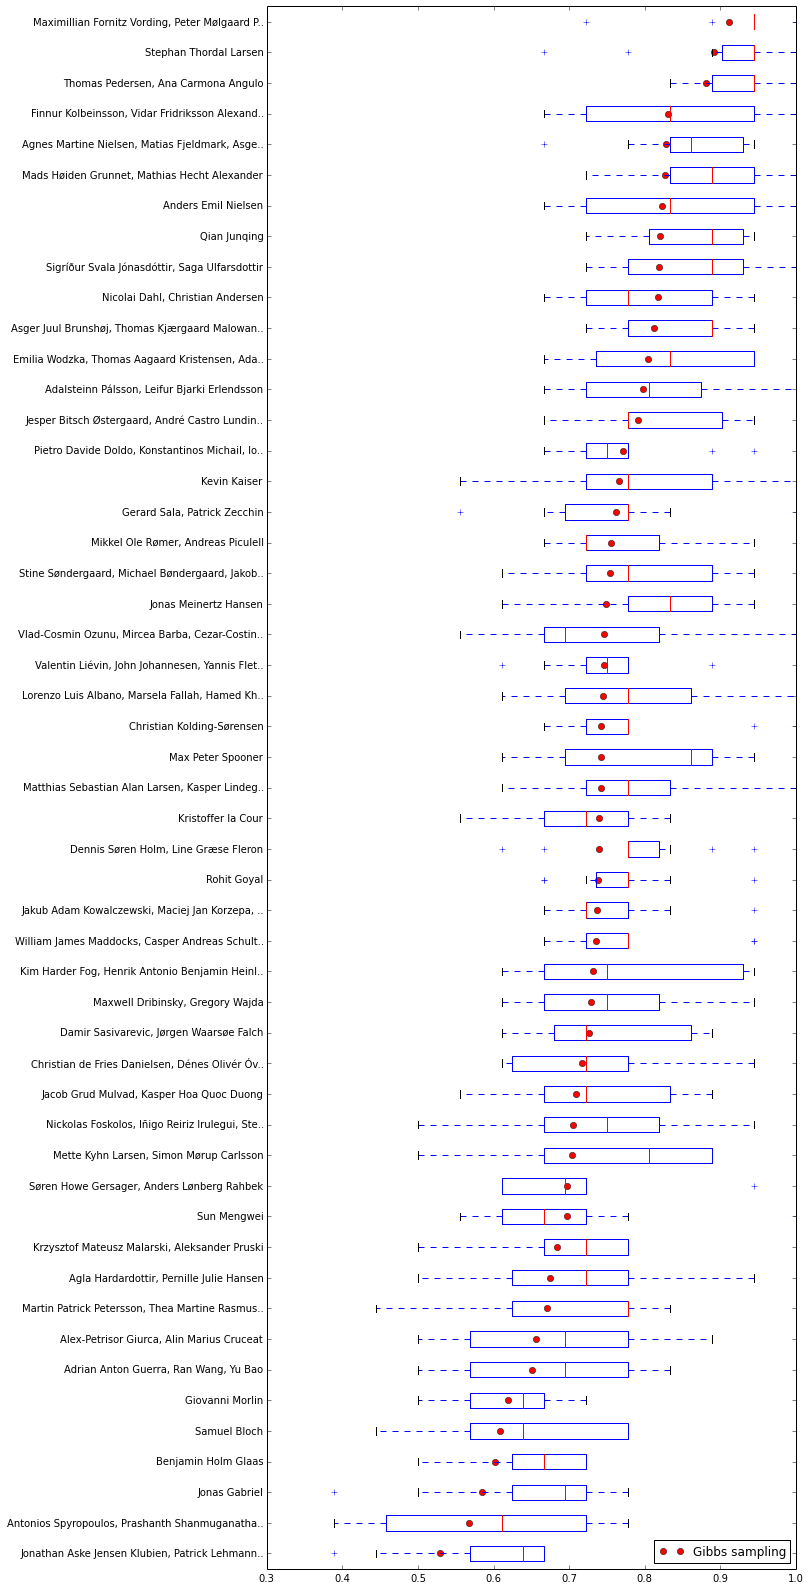

In [302]:
plot_handin_score(a4_data,a4_result)

In [204]:
def plot_all_grader_bias(data_result):
    
    grader_bias = defaultdict(list)
    
    for data,result in data_result:

        for name, g in t.graders.iteritems():
            grader_bias[name].append(result['B'][name])

    scores = list()
    
    for name, values in grader_bias.iteritems():
        scores.append((user_name(ObjectId(name)),values))
    
    ax = plt.subplot(111)

    scores.sort(key=lambda x:np.mean(x[1]))
    model_1 = map(lambda x : x[1],scores)
    model_m = map(lambda x : np.mean(x[1]),scores)
    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.boxplot(model_1,positions=y, vert=False)
    plt.plot(model_m,y,'or',label="Gibbs sampling",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.title("Collected bias of the graders")
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.ylabel("Grader")
    plt.xlabel("Bias")
    plt.show()

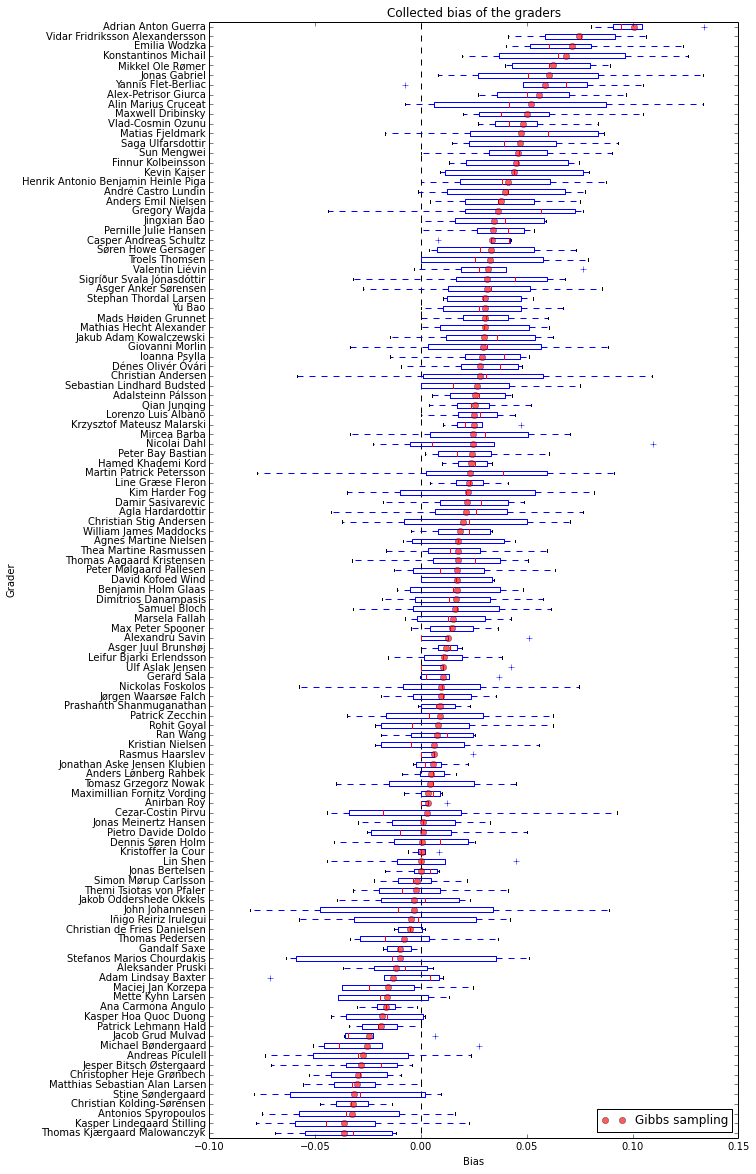

In [205]:
plot_all_grader_bias([(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)])

In [240]:
def print_handin(ass_data,name_):
    for i, (data,result) in enumerate(ass_data):
        print "Assignment %i: " % (i+1),
        u_id = user_id(name_)
        scores = list()

        for h, handin in data.handins.iteritems():

            model_handin = data_model.Handin.objects.get(id=ObjectId(h))

            for student in model_handin.students:
                if student.id == u_id:
                    print np.mean(result['T'][h])
                    break
            else:
                continue  # executed if the loop ended normally (no break)
            break         


In [206]:
def print_bias(course_data,ass_data,name_in):

    print "Course:",
    sr = get_sorted_result(course_data[0],course_data[1])

    for name, value in sr:
        if name_in in name:
            print value

    sum_c = 0.0
    for i , (data,result) in enumerate(ass_data):
        print "Assignment %i:" % (i+1),
        sr = get_sorted_result(data,result)

        for name, value in sr:
            if name_in in name:
                print value
                sum_c = sum_c + value
    print "Mean: %f" % (sum_c / 4.0)

In [304]:
collected_ass_data = [(a1_data,a1_result),(a2_data,a2_result),(a3_data,a3_result),(a4_data,a4_result)]
collected_course_data = (course_data,course_result)

## closer look at  Jesper Bitcsh Østergaard

In [305]:
print_bias(collected_course_data,collected_ass_data,u'Jesper Bitsch Østergaard')

Course: -0.133705202011
Assignment 1: -0.0396462798193
Assignment 2: -0.0219643442262
Assignment 3: -0.0200027649186
Assignment 4: -0.131443460332
Mean: -0.053264


In [215]:
print_bias(collected_course_data,collected_ass_data,u'Jesper Bitsch Østergaard')

Course: -0.0789761134265
Assignment 1: -0.0236161307972
Assignment 2: -0.00428330082791
Assignment 3: -0.0136591555037
Assignment 4: -0.0710126980259
Mean: -0.028143


It seems that the bias in assignment 4 have a very heavy influence on the bias of the entire course which is not ideal

In [307]:
print_handin(collected_ass_data,u'Jesper Bitsch Østergaard')

Assignment 1:  0.823633816711
Assignment 2:  0.947526506562
Assignment 3:  0.784166370132
Assignment 4:  0.791020862614


## Closer look at André Castro Lundin

In [306]:
print_bias(collected_course_data,collected_ass_data,u'Andr\xe9 Castro Lundin')

Course: 0.103780846288
Assignment 1: 0.0109221402564
Assignment 2: 0.131104613494
Assignment 3: -0.0105022516301
Assignment 4: 0.105961241331
Mean: 0.059371


The same as previously but this time it is in the positive direction

In [283]:
print_handin(collected_ass_data,u'Andr\xe9 Castro Lundin')

Assignment 1:  0.793473246117
Assignment 2:  0.929190474768
Assignment 3:  0.759226970015
Assignment 4:  0.776836011117


## Closer look at Jonas Gabriel

In [210]:
print_bias(collected_course_data,collected_ass_data,u'Jonas Gabriel')

Course: 0.00842612940583
Assignment 1: 0.0674363303694
Assignment 2: 0.133248974116
Assignment 3: 0.0333695106971
Assignment 4: 0.00804887030474
Mean: 0.060526


As we can see here the Grader is very much positive biased but if the model is used on the entire course the grader is presented as being netural even though that it is not the case.

In [257]:
print_handin(collected_ass_data,u'Jonas Gabriel')

Assignment 1:  0.449699645118
Assignment 2:  0.436267808366
Assignment 3:  0.681604338848
Assignment 4:  0.602263857121


## Closer look at Adrian Anton Guerra

In [211]:
print_bias(collected_course_data,collected_ass_data,u'Adrian Anton Guerra')

Course: 0.0851253963701
Assignment 1: 0.133563773873
Assignment 2: 0.0941644498255
Assignment 3: 0.0949272921091
Assignment 4: 0.0804293961701
Mean: 0.100771


Here we see a very positive biased person where the model is actually not giving the user grader as high a bias as he actully should have

In [260]:
print_handin(collected_ass_data,u'Adrian Anton Guerra')

Assignment 1:  0.444009850962
Assignment 2:  0.432343705993
Assignment 3:  0.576760585937
Assignment 4:  0.647005018607


## Closer look at myself, Thomas Kjærgaard Malowanczyk

In [212]:
print_bias(collected_course_data,collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Course: -0.0155012796217
Assignment 1: -0.0499590380997
Assignment 2: -0.0141316439247
Assignment 3: -0.0690994921892
Assignment 4: -0.0118984253693
Mean: -0.036272


Here we see a more normal bias where I have received a negtive bias in most assignments. But the bias from the entore course is still lower than any of the bias in the assignments.

With this we can conclude that using MCMC on the entire course does not provide better result even though it provide more data.
The reson for the extreme result is hard to define as it is an unsubervised method so the underlying reasons in MCMC is not definable.
It can be assumed that taking MCMC over multiple assignments introduces more variables as each assignment can differe widely in both the subject, quality of the questions and the knowledge of the graders in both the subject and their abillity to grade.

The next question is if the same problem arrises as we look at handins as a question/task instead of a collection of questions.

In [258]:
print_handin(collected_ass_data,u'Thomas Kjærgaard Malowanczyk')

Assignment 1:  0.762258330788
Assignment 2:  0.809269609188
Assignment 3:  0.729196510121
Assignment 4:  0.804193526054


## Closer look at Christopher Heje Grønbech

In [263]:
print_bias(collected_course_data,collected_ass_data,u'Christopher Heje Grønbech')

Course: -0.012602762471
Assignment 1: -0.0390709204504
Assignment 2: -0.0183723836915
Assignment 3: -0.0528738302866
Assignment 4: -0.0092508413823
Mean: -0.029892


In [262]:
print_handin(collected_ass_data,u'Christopher Heje Grønbech')

Assignment 1:  0.799938550192
Assignment 2:  0.8401262273
Assignment 3:  0.773714690198
Assignment 4:  0.892798337291


## Closer look at Peter Mølgaard Pallesen

In [214]:
print_bias(collected_course_data,collected_ass_data,u'Peter Mølgaard Pallesen')

Course: 0.0644382813495
Assignment 1: -0.0128548662777
Assignment 2: 0.0184550586079
Assignment 3: -0.000777810739385
Assignment 4: 0.0631345753943
Mean: 0.016989


In [272]:
print_handin(collected_ass_data,u'Peter Mølgaard Pallesen')

Assignment 1:  0.799938550192
Assignment 2:  0.8401262273
Assignment 3:  0.773714690198
Assignment 4:  0.892798337291
